In [1]:
# !pip install TTS

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
import nltk
import librosa
import torch
import numpy as np
import pandas as pd
import torchaudio
import random
from transformers import (
    Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2ProcessorWithLM,
    AutoModelForCTC, Wav2Vec2BertProcessor,
    AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline,
    EncodecModel, AutoProcessor
)

import IPython.display as ipd
import torch.nn as nn
import jsonlines

from transformers import AutoTokenizer
from pyctcdecode import build_ctcdecoder
from glob import glob
from tqdm import tqdm

# If import failes - re-start notebook
from TTS.api import TTS

from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

![Image Title](images/intro_meme.jpg)

# Agenda

1. ASR

   1.1 [Intro](#ASR-Intro)

   1.2 [Metrcis](#ASR-Metrics)
   
   1.3 [CTC Approach](#ASR-CTC-Approach)
    
   1.4 [Sequence-to-Sequence Approach](#ASR-Sequence-to-Sequence-Approach)

   1.5 [Homework](#ASR-Homework)

3. TTS

   2.1 [Intro](#TTS-Intro)

   2.2 [Metrics](#TTS-Metrics)
   
   2.3 [General Modern Approach](#TTS-General-Modern-Approach)
   
   2.4 [xTTS](#TTS-xTTS)

   2.5 [Other TTS Models](#TTS-Other-TTS-Models)

   2.5 [Homework](#TTS-Homework)


<a id='ASR-Intro'></a>
# ASR. Intro

## What is ASR?
Automatic Speech Recognition (ASR) is a technology that enables machines to transcribe spoken language into text. This process involves analyzing and interpreting audio waveforms to produce accurate textual representations of spoken words. While ASR has made significant advancements, achieving perfect transcription across various contexts and speakers remains a challenge.

Challenges:
1. **Context and Vocabulary:**
  * ASR systems must accurately transcribe spoken words into textual form. Tasks range from simple commands with limited vocabulary to complex conversations with extensive lexicons.
  * Simple tasks like digit recognition or binary commands exhibit high accuracy, while transcribing conversations or videos with diverse vocabularies poses greater difficulty.
1. **Speaker Variability:**
  * Recognizing speech depends on the speaker's characteristics and the context of communication. Machines generally perform better when humans interact with them directly or when speech is read aloud.
  * Conversational speech, especially in scenarios like business meetings, presents the greatest challenge due to natural variations, interruptions, and overlapping speech.
1. **Environmental Factors:**
  * The environment in which speech is recorded significantly impacts recognition accuracy. Clean, quiet settings with close-range microphones yield better results compared to noisy environments or recordings made at a distance.
  * Noise, such as background chatter or vehicle sounds, can distort speech signals and hinder transcription accuracy.
1. **Accent and Dialect:**
  * ASR systems perform best when trained on speech patterns similar to those they encounter during operation. Recognizing accents, dialects, or speech variations not present in the training data poses difficulties.
  * Variations in pronunciation, intonation, and regional speech patterns challenge ASR accuracy, particularly when encountering diverse speaker demographics.

## Why ASR is important?
ASR technology finds application in various domains, including:

* Human-machine interfaces, enabling voice commands for smart devices and personal assistants. (Siri, Amazon Alexa, Google Assitant)
* Telephony systems for call-routing and automated customer service interactions. (Virtual Call Center in Vodafone or Kyivstar)
* Captioning for audio and video content, enhancing accessibility and user experience. (YouTube, Netflix)
* Transcription services for generating textual records of speeches, interviews, or discussions. (Otter.ai)
* Dictation software for professionals in fields like law and medicine, aiding in documentation tasks. (OpenAI Whisper)

## Create user-friendly dataset

Let's download data!

Credits for data goes to [Yurii Laba](https://www.linkedin.com/in/yura-laba/)

Download data from [Google Drive](https://drive.google.com/file/d/1j9d91QqE7_WnOnmEmidtOG55tpmxQUeJ/view?usp=sharing) and unzip into `../data`

In [4]:
with jsonlines.open("../data/labels.jsonl", 'r') as reader:
  for line in reader:
    labels = line
      
all_audio_files = glob(
    "../data/toronto_*/*.wav",
    recursive=True
)

toronto_dataset = pd.DataFrame({
    "path": all_audio_files
})

toronto_dataset["transcript"] = toronto_dataset["path"].apply(
    lambda x: labels["dataset/" + "/".join(x.split("/")[-2:])]
)

toronto_dataset.shape

(18303, 2)

In [5]:
toronto_dataset.head()

,path,transcript
0,../data/toronto_8/toronto_8_159.wav,"агентурна інформація, у нас є навіть звукова і..."
1,../data/toronto_8/toronto_8_258.wav,"бивнях, шкірах, колонах, арках, картинах, гобе..."
2,../data/toronto_8/toronto_8_176.wav,"Ми не будемо зараз продовжувати дискусію. Ну, ..."
3,../data/toronto_8/toronto_8_166.wav,"Вважаю, що він розпочав її, вважаю, щооо на жа..."
4,../data/toronto_8/toronto_8_107.wav,у неділю Зеленський на гвинтокрилі ДСНС зганяв...


## Base of Base

In [6]:
sample_idx = 3000

toronto_dataset["path"].iloc[sample_idx]

'../data/toronto_43/toronto_43_8.wav'

In [7]:
audio_input, sample_rate_original = librosa.load(toronto_dataset["path"].iloc[sample_idx], sr=None)
print(f"Sample rate: {sample_rate_original}")

Sample rate: 44100


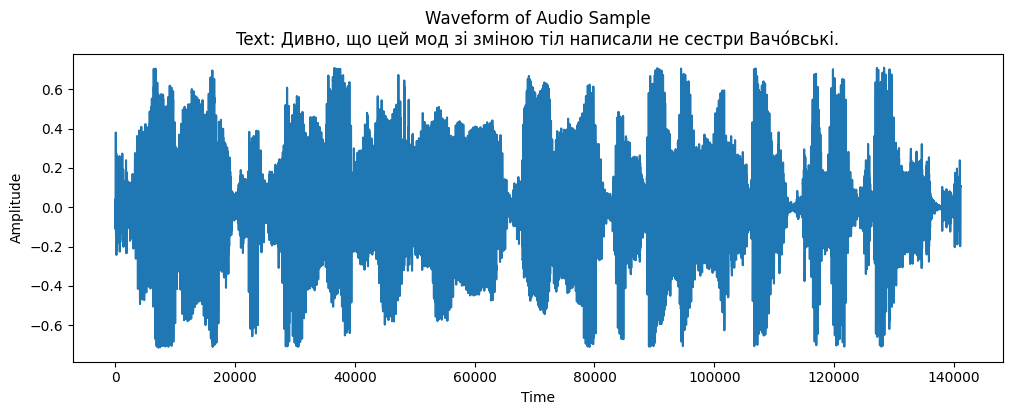

In [8]:
# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_input)
plt.title(f"Waveform of Audio Sample\nText: {toronto_dataset['transcript'].iloc[sample_idx]}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [9]:
ipd.Audio(audio_input, rate=sample_rate_original)

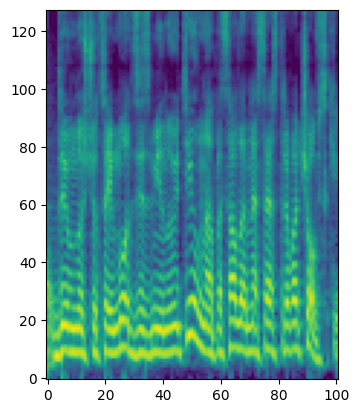

In [10]:
audio_transform = nn.Sequential(
    torchaudio.transforms.Resample(orig_freq=sample_rate_original, new_freq=16000),
    torchaudio.transforms.MelSpectrogram(
        sample_rate=16000, 
        n_mels=128,
        n_fft=1024,
        hop_length=512,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        mel_scale="htk",
    ),
    torchaudio.transforms.AmplitudeToDB(top_db=80)
)

spectogram = audio_transform(
    torch.from_numpy(audio_input).unsqueeze(0)
)[0]

plt.imshow(spectogram, origin="lower")

### Explore More Details

- Module 1

Let's run some Model !!!!!

In [11]:
# Config
ctc_model_name = 'Yehor/w2v-bert-2.0-uk-v2.1'
ctc_sampling_rate = 16_000

# Load the model
ctc_model = AutoModelForCTC.from_pretrained(ctc_model_name).to(DEVICE)
ctc_processor = Wav2Vec2BertProcessor.from_pretrained(ctc_model_name)

# Resample audio
resampler = torchaudio.transforms.Resample(
    sample_rate_original, 
    16_000, 
)
resampled_audio = resampler(
    torch.from_numpy(audio_input).unsqueeze(0).float()
).squeeze(0).numpy()

# Transcribe the audio
inputs = ctc_processor(
    [resampled_audio], 
    sampling_rate=ctc_sampling_rate
).input_features
features = torch.tensor(inputs).to(DEVICE)

with torch.inference_mode():
  logits = ctc_model(features).logits

predicted_ids = torch.argmax(logits, dim=-1)
predictions = ctc_processor.batch_decode(predicted_ids)

# Log results
print('Predictions:')
print(predictions)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Predictions:
['дивно що цей мод зі зміною тіл написали несестривачовські']


<a id='ASR-Metrics'></a>
# ASR. Metrics

An objective of ASR can be stated, as to develop a model that reduces the Word Error Rate (WER) metric when converting speech input into text. Essentially, when presented with an audio file, such as a WAV file containing speech, our aim is to accurately transcribe it into text with minimal errors.

In [12]:
import numpy as np

def levenshtein_distance(ref, hyp):
    """Calculates the Levenshtein distance between two sequences."""
    m, n = len(ref), len(hyp)

    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    previous_row = range(n + 1)
    for i, c1 in enumerate(ref):
        current_row = [i + 1]
        for j, c2 in enumerate(hyp):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

def normalize_text(text, ignore_case=False, remove_space=False):
    """Normalizes text based on the specified conditions."""
    if ignore_case:
        text = text.lower()
    if remove_space:
        text = ''.join(text.split())
    return text

def calculate_errors(reference, hypothesis, ignore_case=False, remove_space=False, delimiter=None):
    """Calculates edit distance and length/reference length based on the mode (word or char level)."""
    reference = normalize_text(reference, ignore_case, remove_space)
    hypothesis = normalize_text(hypothesis, ignore_case, remove_space)

    if delimiter:
        reference = reference.split(delimiter)
        hypothesis = hypothesis.split(delimiter)

    edit_distance = levenshtein_distance(reference, hypothesis)
    ref_len = len(reference)

    return float(edit_distance), ref_len

def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculates word error rate."""
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, False, delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    return edit_distance / ref_len

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculates character error rate."""
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    return edit_distance / ref_len

In [13]:
predictions[0]

'дивно що цей мод зі зміною тіл написали несестривачовські'

In [14]:
toronto_dataset['transcript'].iloc[sample_idx]

'Дивно, що цей мод зі зміною тіл написали не сестри Вачо́вські.'

In [15]:
toronto_dataset['transcript'].iloc[0]

'агентурна інформація, у нас є навіть звукова інформація, де представники з України, скажімо так,'

In [16]:
print(
    "Ideal Case\n"+
    f"CER: {cer(toronto_dataset['transcript'].iloc[sample_idx], toronto_dataset['transcript'].iloc[sample_idx])}\n"+
    f"WER: {wer(toronto_dataset['transcript'].iloc[sample_idx], toronto_dataset['transcript'].iloc[sample_idx])}\n"
)

print(
    "Nearly worst Case\n"+
    f"CER: {cer(toronto_dataset['transcript'].iloc[sample_idx], toronto_dataset['transcript'].iloc[0])}\n"+
    f"WER: {wer(toronto_dataset['transcript'].iloc[sample_idx], toronto_dataset['transcript'].iloc[0])}\n"
)

print(
    "Real Prediction\n"+
    f"CER: {cer(toronto_dataset['transcript'].iloc[sample_idx], predictions[0])}\n"+
    f"WER: {wer(toronto_dataset['transcript'].iloc[sample_idx], predictions[0])}\n"
)

Ideal Case
CER: 0.0
WER: 0.0

Nearly worst Case
CER: 1.1935483870967742
WER: 1.2727272727272727

Real Prediction
CER: 0.11290322580645161
WER: 0.36363636363636365



In [17]:
# Play a bit with metric

# cer(
#     toronto_dataset['transcript'].iloc[sample_idx], 
#     "a"*1
# )
# wer(
#     toronto_dataset['transcript'].iloc[sample_idx], 
#     "a "*1000
# )

### Explore More Details

- Module 3. Lecture 1

<a id='ASR-CTC-Approach'></a>
# ASR. CTC Approach

![Image Title](images/basic_decoding.png)

***Figure**: A naive algorithm for collapsing an alignment between input and letters.*

![Image Title](images/ctc.png)

![Image Title](images/ctc1.png)

![Wav2Vec description](images/wave2vec2_shorten.png)

**Feature encoder**: This is the encoder part of the model. It takes the raw audio data as input and outputs feature vectors. Input size is limited to 400 samples, which is 20ms for a 16kHz sample rate. The raw audio is first standardized to have zero mean and unit variance. Then, it is passed to the 1D convolutional neural network (temporal convolution), followed by layer normalization and GELU activation function. There could be seven such convolution blocks with constant channel size (512), decreasing kernel width (10, 3x4, 2x2), and stride (5, 2x6). The output is a list of feature vectors, each with 512 dimensions.

**Transformers**: The output of the feature encoder is passed on to a transformer layer. One differentiator is the use of relative positional embedding by using convolution layers rather than fixed positional encoding, as done in the original Transformers paper. The block size differs, as 12 transformer blocks with a model dimension of 768 are used in the BASE model but 24 blocks with a dimension of 1024 in the LARGE version.

**Quantization module**: We need to work with discrete outputs for self-supervised learning. For this, there is a quantization module that converts the continuous vector output to discrete representations, and on top of it, it automatically learns the discrete speech units. It is done by maintaining multiple codebooks/groups (320 in size), and the units sampled from each codebook are later concatenated (320x320=102,400 possible speech units). The sampling is done using Gumbel-Softmax, which is like argmax but differentiable.

**Training Phases**

1. Pretrain in Self-Supervised Mode
2. Fine-tune for ASR

Explore in details in Wave2Vec papers:
- [V1](https://arxiv.org/abs/1904.05862)
- [V2](https://arxiv.org/abs/2006.11477)

## A decoding algorithm and a loss function. And who is CTC ?

![Image Title](images/ctc_meme.jpg)

The intuition of CTC is to output a single character for every frame of the input so that the output is the same length as the input and then to apply a collapsing function that combines sequences of identical letters, resulting in a shorter sequence.

Let's imagine inference on someone saying the word dinner, and suppose we had a function that chooses the most probable letter for each input spectral frame representation $x_i$. We'll call the sequence of letters corresponding to each input frame an alignment because it tells us where each letter aligns in the acoustic signal. **Figure 1** shows one such alignment and what happens if we use a collapsing function that just removes consecutive duplicate letters.

![Image Title](images/basic_decoding.png)

***Figure**: A naive algorithm for collapsing an alignment between input and letters.*

That doesn't work; our naive algorithm has transcribed the speech as a `diner`, not `dinner`! Collapsing doesn't handle double letters. Another problem with our naive function is that it doesn't tell us what symbol to align with silence in the input. We don't want to be transcribing silence as random letters!

### The key decoding problem
1. We have to decode `RRROODD`.
2. Is it a `ROD` or `ROOD`?

The CTC algorithm solves both problems by adding a special symbol for a blank to the transcription alphabet, which we'll represent `⌴`. The blank can be used in the alignment whenever we don't want to transcribe a letter. It also can be used between letters; since our collapsing function collapses only consecutive duplicate letters, it won't collapse across `⌴`. More formally, let's define the mapping $B : a → y$ between an alignment $a$ and an output $y$, which collapses all repeated letters and then removes all blanks. **Figure 2** sketches this collapsing function $B$.

![Image Title](images/ctc_collapsing_function.png)

***Figure**: The CTC collapsing function $B$, showing the space blank character `⌴`; repeated (consecutive) characters in an alignment $A$ are removed to form the output $Y$.*

The CTC collapsing function is many-to-one; many different alignments map to the exact output string. For example, the alignment shown in **Figure 2** is not the only one resulting in the string dinner. **Figure 2** shows some other alignments that would produce the same output. We'll use the inverse of our B function, called $B^{-1}$, and represent that set as $B^{-1}(Y)$.

### CTC Inference

Before we see how to compute $P_{CTC}(Y|X)$, let's first see how CTC assigns a probability to one particular alignment $\hat{A} = { \hat{a}_1, \ldots, \hat{a}_n }$. CTC makes a strong conditional independence assumption: it assumes that, given the input $X$, the CTC model output $a_t$ at time $t$ is independent of the output labels at any other time $a_i$. Thus:
$$P_{\text{ctc}}(A|X) = \prod_{t=1}^{T} p(a_t | X)$$

Thus to find the best alignment $\hat{A} = { \hat{a}_1, \ldots, \hat{a}_n }$, we can greedily choose the character with the max probability at each time step t: 
$$a_t = \text{argmax}_{c \in C} p_t(c | X)$$

We then pass the resulting sequence $A$ to the CTC collapsing function $B$ to get the output sequence $Y$.

We implemented the Best path decoding. It is the simplest method to decode the output matrix:
1. Concatenate most probable characters per timestep which yields the best path.
2. Then, undo the encoding by removing duplicate characters and all blanks. This gives us the recognized text.

You can see an example of the Best path decoding.

![Image Title](images/most_likely_characters.png)

***Figure**: Concatenate most probable characters per timestep to get best path.*

### Why best path decoding can fail

![Image Title](images/all_paths_to_a.png)

***Figure**: All paths corresponding to text "a".*

Best path decoding is both fast and simple, which are of course nice properties. But it may fail in certain situations like the one shown in **Fig 2**. In **Fig. 4** all paths corresponding to the text “a” are shown: `aa`, `a⌴` and `⌴a`. The probability of the text `a` is the sum over all probabilities of these mentioned paths: 0.2·0.4+0.2·0.6+0.8·0.4=0.52. So, `a` is more probable than `⌴` (0.52>0.48). We need a better algorithm than best path decoding which can handle such situations.

For this reason, the most probable output sequence $Y$ is the one that has not the single best CTC alignment but the highest sum over the probability of all its possible alignments:

$$P_{\text{CTC}}(Y|X) = \sum_{A \in B^{-1}(Y)} P(A|X) = \sum_{A \in B^{-1}(Y)} \prod_{t=1}^{T} p(a_t|h_t)$$

where $h_t$ is a hidden state of the encoder at timestep $t$.

$$Y = \text{argmax}_Y P_{\text{CTC}}(Y|X)$$

But summing over all alignments is very expensive (there are a lot of alignments).

<img src="images/semi_tree.png" alt="Image 1" style="width: 50%; height: 50%">
<img src="images/decoding_graph.png" alt="Image 2" style="width: 50%; height: 50%">

Let's predict all our dataset with CTC ASR Model and compute Metrics

In [ ]:
# Config
batch_size = 16  # Adjust batch size according to your GPU memory


# Function to load and resample audio
def load_and_preprocess_audio(audio_paths, inp_resampler):
    resampled_audios = []
    for path in audio_paths:
        # Load the audio file
        waveform, original_sample_rate = torchaudio.load(path)
        
        # Resample audio
        resampled_audio = inp_resampler(waveform).squeeze(0).numpy()
        
        resampled_audios.append(resampled_audio)
    
    return resampled_audios

# Transcribe the audio in batches
def transcribe_batch(audio_list, inp_processor, inp_model):
    inputs = inp_processor(
        audio_list, 
        sampling_rate=ctc_sampling_rate,
        return_tensors="pt",
        padding=True
    ).input_features
    
    features = inputs.to(DEVICE)
    
    with torch.inference_mode():
        logits = inp_model(features).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    predictions = inp_processor.batch_decode(predicted_ids)
    
    return predictions

# Example list of audio file paths
audio_paths = toronto_dataset["path"].to_list()

# Process in batches
ctc_predictions = []
for i in tqdm(range(0, len(audio_paths), batch_size)):
    batch_paths = audio_paths[i:i + batch_size]
    resampled_audios = load_and_preprocess_audio(batch_paths, inp_resampler=resampler)
    batch_predictions = transcribe_batch(
        resampled_audios,
        inp_processor=ctc_processor,
        inp_model=ctc_model
    )
    ctc_predictions.extend(batch_predictions)

  2%|███▏                                                                                                                                                               | 22/1144 [01:25<1:06:47,  3.57s/it]

In [ ]:
n_samples = len(ctc_predictions)

toronto_ctc_mean_cer = np.mean([
    cer(y_true, y_pred) for y_true, y_pred in tqdm(zip(toronto_dataset["transcript"], ctc_predictions))
    if len(y_true) > 0
])

toronto_ctc_mean_wer = np.mean([
    wer(y_true, y_pred) for y_true, y_pred in tqdm(zip(toronto_dataset["transcript"], ctc_predictions))
    if len(y_true) > 0
])

In [ ]:
print(
    "CTC Model Metrics:\n"+
    f"CER: {toronto_ctc_mean_cer}\n"+
    f"WER: {toronto_ctc_mean_wer}\n"
)

### Explore More Details

- Module 3. Lecture 1
- Module 3. Lecture 2

<a id='ASR-Sequence-to-Sequence-Approach'></a>
# ASR. Sequence-to-Sequence Approach

![](images/llms_all_meme.jpg)

![Image Title](images/whisper_architecture.png)

*Whisper architecture.*

## Whisper summary

![Image Title](images/whisper_tasks.png)

*Whisper tasks.*

**Data-processing**

1. No specific data pre-processing applied.
2. Developed several automated filtering methods to improve transcript quality.
3. Developed many heuristics to detect and remove machine-generated transcripts from the training dataset.
    1. An all-uppercase or all-lowercase transcript is very unlikely to be human-generated.
4. Use an audio language detector to ensure that the spoken language matches the language of the transcript according to CLD2.
5. Break audio files into 30-second segments paired with the subset of the transcript that occurs within that time segment.
6. Train on all audio, including segments with no speech (though with sub-sampled probability), and use these segments as training data for voice activity detection.
7. After training an initial model, they aggregated information about its error rate on training data sources. They manually inspected these data sources, sorting by a combination of high error rates and data source size to identify and remove low-quality ones efficiently.

**Model**

1. Using an off-the-shelf architecture avoids confounding our findings with model improvements.
2. Choose an encoder-decoder Transformer.
3. All audio is re-sampled to 16,000 Hz, and an 80-channel log-magnitude Mel spectrogram representation is computed on 25 millisecond windows with a stride of 10 milliseconds.
4. They globally scale the input between -1 and 1 with approximately zero mean across the pre-training dataset for feature normalization.
5. They use the same byte-level BPE text tokenizer used in GPT-2 for the English-only models and refit the vocabulary (but keep the same size) for the multilingual models to avoid excessive fragmentation on other languages since the GPT-2 BPE vocabulary is English-only.

**Multitask Format**

1. Since their decoder is an audio-conditional language model, they also train it to condition the history of the transcript's text in the hope that it will learn to use longer-range text context to resolve ambiguous audio.
2. Specifically, with some probability, they add the transcript text preceding the current audio segment to the decoder's context.
3. A sequence-to-sequence Transformer model is trained on many different speech processing tasks, including multilingual speech recognition, speech translation, spoken language identification, and voice activity detection. These tasks are jointly represented as a sequence of tokens to be predicted by the decoder, allowing for a single model to replace many stages of a traditional speech-processing pipeline.

![Image Title](images/whisper_multitask.png)

In [ ]:
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

seq2seq_model_name = "openai/whisper-large-v3"

seq2seq_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    seq2seq_model_name, 
    torch_dtype=torch_dtype, 
    low_cpu_mem_usage=True, 
    use_safetensors=True
)
seq2seq_model.to(DEVICE)

seq2seq_processor = AutoProcessor.from_pretrained(seq2seq_model_name)

pipe = pipeline(
    "automatic-speech-recognition",
    model=seq2seq_model,
    tokenizer=seq2seq_processor.tokenizer,
    feature_extractor=seq2seq_processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=DEVICE,
)

In [ ]:
pipe(toronto_dataset["path"].iloc[sample_idx])

In [ ]:
seq2seq_predictions = pipe(
    toronto_dataset["path"].iloc[:n_samples].to_list(), 
    batch_size=16,
    generate_kwargs={"language": "ukrainian"}
)
seq2seq_predictions = [el["text"] for el in seq2seq_predictions]

In [ ]:
toronto_seq2seq_mean_cer = np.mean([
    cer(y_true, y_pred) for y_true, y_pred in tqdm(zip(toronto_dataset["transcript"], seq2seq_predictions))
    if len(y_true) > 0
])

toronto_seq2seq_mean_wer = np.mean([
    wer(y_true, y_pred) for y_true, y_pred in tqdm(zip(toronto_dataset["transcript"], seq2seq_predictions))
    if len(y_true) > 0
])

In [ ]:
print(
    "Seq2Seq Model Metrics:\n"+
    f"CER: {toronto_seq2seq_mean_cer}\n"+
    f"WER: {toronto_seq2seq_mean_wer}\n"
)

### Explore More Details

- Module 3. Lecture 3

<a id='ASR-Homework'></a>
# ASR. Homework

In [ ]:
toronto_dataset["full_lines"] = toronto_dataset["path"].apply(lambda x: x.split("/")[-2])

In [ ]:
test_lines = [
    'toronto_27',
    'toronto_46',
    'toronto_42',
    'toronto_37',
    'toronto_89',
    'toronto_43',
    'toronto_157',
    'toronto_9',
    'toronto_156',
    'toronto_7',
    'toronto_123',
    'toronto_54',
    'toronto_67',
    'toronto_62',
    'toronto_81',
    'toronto_134',
    'toronto_148',
    'toronto_21',
    'toronto_135',
    'toronto_166',
    'toronto_58'
]

In [ ]:
toronto_dataset_train = toronto_dataset[
    ~toronto_dataset["full_lines"].isin(test_lines)
].reset_index(drop=True)

toronto_dataset_test = toronto_dataset[
    toronto_dataset["full_lines"].isin(test_lines)
].reset_index(drop=True)

print(
    f"Train Length: {toronto_dataset_train.shape[0]}" + "\n"
    f"Test Length: {toronto_dataset_test.shape[0]}"
)

In [ ]:
set(toronto_dataset_train["full_lines"]) & set(toronto_dataset_test["full_lines"])

In [ ]:
set(toronto_dataset_train["path"]) & set(toronto_dataset_test["path"])

In [ ]:
set(toronto_dataset_train["transcript"]) & set(toronto_dataset_test["transcript"])

## Task

Fine-tune W2V2 Bert OR Whisper V3 on `toronto_dataset_train` and compare metrics with basic models

1. Take one of 2 next tutorials:
    - [W2V2 Bert](https://huggingface.co/blog/fine-tune-w2v2-bert)
    - [Whisper V3](https://billtcheng2013.medium.com/openai-whisper-fine-tuning-f519be0f6d4a)
2. Tutorials are pretty detailed. The only important thing to do is to transform dataset into huggingface format. Let it be a task for you to research a bit :)
3. Evaluate your models on `toronto_dataset_test`. **IMPORTANT**: Do not forget to re-compute Lecture model metrics exactly on this subset

P.S.

If you are afraid that you may lack computational resources - [there is an example](https://www.kaggle.com/code/vladimirsydor/phoneme-recognition-with-wav2vec2) of pretty similar fine-tuning but for phoneme recognition task on Kaggle

<a id='TTS-Intro'></a>
# TTS. Intro

## [Speech Synthesis](https://paperswithcode.com/task/speech-synthesis)

Speech synthesis is the task of generating speech from some other modality like text, lip movements, etc.

**Subtasks**:

- Text To Speech (TTS) — Synthesize audio from text. [Coqui.ai](https://github.com/coqui-ai/TTS).
- [Text(Speech) To Speech Translation](https://paperswithcode.com/task/text-to-speech-translation) — Synthesize audio in another language from the original one OR original audio + translated text. [SeamlessM4T](https://huggingface.co/spaces/facebook/seamless_m4t).
- Vocoding — Synthesize audio from spectral or other intermidiate representations.

**Examples**:

- Pure TTS services: [Respeecher](https://www.respeecher.com/), [ElevenLabs](https://elevenlabs.io/) and many other startups and companies.
- Assistive Technology for Visually Impaired — TTS is crucial in screen readers and other assistive technologies, enabling visually impaired individuals to consume digital text content, including books, websites, and documents.
- Navigation and GPS Systems — In GPS and navigation apps, TTS provides spoken directions and traffic updates, allowing users to focus on driving without needing to look at the screen.
- Public Announcements — Airports, train stations, and public venues use TTS for announcements, ensuring clear and consistent communication of important information like boarding calls or emergency alerts.
- Audio Books and Storytelling — TTS technology allows for the creation of audiobooks from written content, making literature more accessible and convenient for busy individuals or those who prefer listening over reading.
- Automated News Reading and Podcasts — TTS is used to convert written news articles, blogs, and other content into spoken words, creating automated news reading services or podcasts.

![](images/diagrams-speech_synthesis.drawio.png)

Let's generate something finally!

In order to use TTS models we will use [coqui-ai/TTS](https://github.com/coqui-ai/TTS) repository

In [ ]:
xtts_v2 = TTS("tts_models/multilingual/multi-dataset/xtts_v2").to(DEVICE)

In [ ]:
# generate speech by cloning a voice using default settings
text_to_generate = "Good afternoon, everyone! Welcome to an exciting journey into the world of Text-to-Speech technology, where we transform text into spoken words, giving machines the ability to communicate with us in a natural and human-like manner. Today, at Kyiv Polytechnic University, we'll explore the fascinating mechanics behind TTS models, how they are revolutionizing various industries, and the incredible potential they hold for the future. Whether you're a seasoned expert or just curious about this technology, there's something here for everyone. Let's dive in and see how text becomes voice!"
xtts_v2_wave = xtts_v2.tts(
    text=text_to_generate,
    speaker="Ana Florence",
    language="en",
    split_sentences=True
)

In [ ]:
# Plot the waveform
plt.figure(figsize=(12, 4))
plt.plot(xtts_v2_wave)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
ipd.Audio(xtts_v2_wave, rate=24000)

<a id='TTS-Metrics'></a>
# TTS. Metrics

![](images/tts_metrics_meme.jpg)

## High-Level Criteria for TTS Model Evaluation

### Primary Criteria:
- **Phonetic Accuracy**: How well does the TTS model replicate the pronunciation and articulation of the text?
- **Naturalness**: Does the model sound like a real human? This includes natural pronunciation, appropriate pauses, and intonation, avoiding the "robotic" sound typical of older TTS systems.
- **Speaker Identity**: How closely does the model mimic the voice of the target speaker?

### Additional Considerations:
- **Emotional Expressiveness**: Is the model capable of conveying a range of emotions? This is crucial for synthesizing lively dialogues, as opposed to monotone audiobook narration.
- **Duration Control**: Can the model generate audio within specific time constraints, if required?
- **Other Factors**: Additional criteria might be relevant depending on the use case, such as noise reduction, cross-language capabilities, etc.

## Evaluation Metrics

### Subjective

#### Pros
- **Human Perception**: Directly reflects how end-users experience the TTS output.
- **Context Sensitivity**: Can account for nuances like emotion and intonation that automated metrics might miss.
- **Flexibility**: Can be adapted to different evaluation scenarios, such as conversational dialogue vs. audiobook narration.

#### Cons
- **Time-Consuming**: Requires significant human effort to collect and analyze feedback.
- **Subjectivity**: Results can vary between evaluators, leading to inconsistent outcomes.
- **Scalability**: Difficult to apply on a large scale or across diverse languages and dialects.
- **Impossible to compare different models**: Best case scenario is to have one focus group for all studies but it is impossible

#### Examples
- **Mean Opinion Score (MOS)**: Participants rate the quality of speech on a scale from 1 to 5.
- **ABX Testing**: Evaluators choose which of two samples better matches a reference.
- **Speaker Similarity**: Listeners assess how closely the synthesized voice matches the target speaker.

### Objective

#### Pros
- **Consistency**: Provides reproducible and quantifiable results that are not influenced by individual biases.
- **Efficiency**: Can be automated and applied to large datasets, enabling rapid evaluation.
- **Scalability**: Easily applied across different languages, dialects, and contexts.

#### Cons
- **Lack of Perception Insight**: May not fully capture how humans perceive the synthesized speech.
- **Limited Contextual Sensitivity**: May overlook subtleties like emotion, prosody, or speaker identity.
- **Mismatch with Human Judgment**: Objective metrics may not always correlate with subjective human evaluations.

#### Examples
- **Phoneme Error Rate (PER)**: Measures accuracy of phoneme pronunciation against a reference. Phoneme are extracted using phoneme prediction model, for example fine-tuned for this task Wave2Vec
- **Word Error Rate (WER)**: Assesses the accuracy of word transcription. Transcription is extracted using ASR model
- **Speaker Encoder Cosine Similarity**: Extracts speaker embedding with neural net and compute distance. 
- **Predicted Naturalness Mean Opinion Score**: Special model to predict MOS, for example [UTMOS](https://arxiv.org/abs/2204.02152)

**I refer you to [xTTS paper](https://arxiv.org/abs/2406.04904), where they have used a bunch of obejctive and subjective metrics for TTS evaluation**}

Let's check WER of our sample

In [ ]:
resampler = torchaudio.transforms.Resample(
    24000, 
    16_000, 
)
resampled_audio = resampler(
    torch.tensor(xtts_v2_wave).unsqueeze(0).float()
).squeeze(0).numpy()

xtts_v2_transcript = pipe(resampled_audio)["text"]

xtts_v2_transcript

In [ ]:
print(f"WER(referance, xTTS -> Whisper V3): {wer(text_to_generate, xtts_v2_transcript)}")

<a id='TTS-General-Modern-Approach'></a>
# TTS. General Modern Approach

![](images/llms_all_meme.jpg)

## General concept 

```
A mathematician and a physicist were given the same task: to boil a kettle. The available tools were a stove, a kettle, a water tap, and matches. Both of them, in turn, filled the kettle with water, turned on the gas, lit it, and placed the kettle on the flame.

Then the task was simplified: they were given a kettle already filled with water and a stove with the gas already lit. The goal remained the same — to boil the water. The physicist placed the kettle on the flame. The mathematician poured the water out of the kettle, turned off the gas, and said, 'The problem has been reduced to the previous one.'
```

1. Transform continuous waveform into a discrete representation
2. Concatenate discrete text representations and audio representations
3. Apply language modeling to predict audio representations from text
4. Decode discrete audio representations back into a waveform

![](images/valle_scheme.png)

***Figure**: Taken from [Neural Codec Language Models are Zero-Shot Text to Speech Synthesizers](https://arxiv.org/abs/2301.02111)*

## Step 1 and 4. Encode and Decode audio into Discrete Representations

![](images/encodec.png)

***Figure**: Taken from [High Fidelity Neural Audio Compression](https://arxiv.org/abs/2210.13438)*

In [ ]:
# load the model + processor (for pre-processing the audio)
encodec_model = EncodecModel.from_pretrained("facebook/encodec_32khz")
encodec_processor = AutoProcessor.from_pretrained("facebook/encodec_32khz")

encodec_model.to(DEVICE);

In [ ]:
# Resample audio
resampler = torchaudio.transforms.Resample(
    sample_rate_original, 
    32_000, 
)
resampled_audio = resampler(
    torch.from_numpy(audio_input).unsqueeze(0).float()
).squeeze(0).numpy()

In [ ]:
ipd.Audio(resampled_audio, rate=32_000)

In [ ]:
# pre-process the inputs
inputs = encodec_processor(
    raw_audio=resampled_audio, 
    sampling_rate=encodec_processor.sampling_rate, 
    return_tensors="pt"
)

# explicitly encode then decode the audio inputs
with torch.inference_mode():
    encoder_outputs = encodec_model.encode(inputs["input_values"].to(DEVICE), inputs["padding_mask"].to(DEVICE))
    audio_values = encodec_model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]

In [ ]:
ipd.Audio(audio_values[0,0].cpu().numpy(), rate=32_000)

In [ ]:
encoder_outputs.audio_codes

## Step 3 and 4. Audio Language Modelling and "High Level Residuals" Reconstruction

![](images/valle_ar_nar.png)

***Figure**: Taken from [Neural Codec Language Models are Zero-Shot Text to Speech Synthesizers](https://arxiv.org/abs/2301.02111)*

To synthesize speech, you should perform 2 steps:

1. Take encoded text (G2P stands for Grapheme to Phonemes; after that, you simply introduce an embedding matrix for each phoneme) and target speaker discrete speech codes. So you have the next sequence [Phonemes, Target Speaker Codes, ...], and now for `...` you predict first-level EncoDec codes
2. Than you take Non Autoregressive Transformer and predict Higher Level codes

### Explore More Models and Modifications

![](images/speech_trident.png)

***Figure**: Taken from [speech-trident GitHub](https://github.com/ga642381/speech-trident)*

<a id='TTS-xTTS'></a>
# TTS. xTTS

![](images/xtts_main_scheme.png)

***Figure**: Taken from [XTTS: a Massively Multilingual Zero-Shot Text-to-Speech Model](https://arxiv.org/abs/2406.04904)*

## Main Ideas

- **VQ-VAE**: xTTS also uses discrete audio representations BUT it does not use several level Codecs but only one level codec
- **GPT-2 Encoder**: It is really a decoder-only model, and it decoded text tokens and speaker conditions into audio tokens. But in the whole framework it is Encoder, because it "encodes" audio into latent representations. Also pay attention - only 443M, not billions like in NLP models
- **Byte-Pair Encoding**: Explore it in more details in [original article](http://www.pennelynn.com/Documents/CUJ/HTML/94HTML/19940045.HTM). Pay attention that it is not graphemes or phonemes, so we pass more information to the model. At the same time increasing task complexity
- **Perceiver Resampler**: Special Attention Module in order to supply target speaker condition

![](images/perceiver_resampler.png)

***Figure**: Taken from [Flamingo: a Visual Language Model for Few-Shot Learning](https://arxiv.org/abs/2204.14198)*

- <span style="color: red;">**Decode NOT centroids but latents**</span>: Audio Decoder is [HiGi-GAN](https://arxiv.org/abs/2010.05646) and it is trained on GPT latents before final linear
- **Additional Speaker embedding to Audio Decoder** - [H/ASP model](https://arxiv.org/pdf/2009.14153) is used to extract embedding for Vocoder
- **Speaker Consistency Loss** - Simply extract speaker embeddings with pre-trained NN and minimize difference between them

![](images/scl_loss.png)

***Figure**: Taken from [YourTTS: Towards Zero-Shot Multi-Speaker TTS and Zero-Shot Voice Conversion for everyone](https://arxiv.org/abs/2112.02418)*

Let's experiment a bit with sampling parameters and languages

- `temperature`: The softmax temperature of the autoregressive model. Defaults to 0.65.

- `length_penalty`: A length penalty applied to the autoregressive decoder. Higher settings causes the model to produce more terse outputs. Defaults to 1.0.

- `repetition_penalty`: A penalty that prevents the autoregressive decoder from repeating itself during decoding. Can be used to reduce the incidence of long silences or “uhhhhhhs”, etc. Defaults to 2.0.

- `top_k`: Lower values mean the decoder produces more “likely” (aka boring) outputs. Defaults to 50.

- `top_p`: Lower values mean the decoder produces more “likely” (aka boring) outputs. Defaults to 0.8.

- `speed`: The speed rate of the generated audio. Defaults to 1.0. (can produce artifacts if far from 1.0)

In [ ]:
text_to_generate = "Good afternoon, everyone! Welcome to an exciting journey into the world of Text-to-Speech technology, where we transform text into spoken words, giving machines the ability to communicate with us in a natural and human-like manner. Today, at Kyiv Polytechnic University, we'll explore the fascinating mechanics behind TTS models, how they are revolutionizing various industries, and the incredible potential they hold for the future. Whether you're a seasoned expert or just curious about this technology, there's something here for everyone. Let's dive in and see how text becomes voice!"
xtts_v2_wave_temp04 = xtts_v2.tts(
    text=text_to_generate,
    speaker="Ana Florence",
    language="en",
    split_sentences=True,
    temperature=0.4
)

xtts_v2_wave_temp08 = xtts_v2.tts(
    text=text_to_generate,
    speaker="Ana Florence",
    language="en",
    split_sentences=True,
    temperature=0.8
)

In [ ]:
# Default temperature=0.65
ipd.Audio(xtts_v2_wave, rate=24000)

In [ ]:
ipd.Audio(xtts_v2_wave_temp04, rate=24000)

In [ ]:
ipd.Audio(xtts_v2_wave_temp08, rate=24000)

In [ ]:
text_to_generate_fr = "Bonjour à tous ! Bienvenue dans un voyage passionnant au cœur de la technologie Text-to-Speech, où nous transformons le texte en mots parlés, donnant ainsi aux machines la capacité de communiquer avec nous de manière naturelle et humaine. Aujourd'hui, à l'Université Polytechnique de Kyiv, nous explorerons les mécanismes fascinants qui se cachent derrière les modèles TTS, comment ils révolutionnent diverses industries et le potentiel incroyable qu'ils détiennent pour l'avenir. Que vous soyez un expert chevronné ou simplement curieux à propos de cette technologie, il y en a pour tous les goûts. Plongeons ensemble pour découvrir comment le texte devient voix !"
text_to_generate_de = "Guten Tag, alle zusammen! Willkommen zu einer spannenden Reise in die Welt der Text-to-Speech-Technologie, bei der wir Text in gesprochene Worte verwandeln und Maschinen die Fähigkeit geben, auf natürliche und menschliche Weise mit uns zu kommunizieren. Heute, an der Polytechnischen Universität Kiew, werden wir die faszinierende Mechanik hinter TTS-Modellen erkunden, wie sie verschiedene Industrien revolutionieren und welches unglaubliche Potenzial sie für die Zukunft bergen. Egal, ob Sie ein erfahrener Experte sind oder einfach nur neugierig auf diese Technologie – hier ist für jeden etwas dabei. Tauchen wir ein und sehen wir, wie Text zu Sprache wird!"

xtts_v2_wave_fr = xtts_v2.tts(
    text=text_to_generate_fr,
    speaker="Ana Florence",
    language="fr",
    split_sentences=True,
)
xtts_v2_wave_de = xtts_v2.tts(
    text=text_to_generate_de,
    speaker="Ana Florence",
    language="de",
    split_sentences=True,
)

In [ ]:
ipd.Audio(xtts_v2_wave_fr, rate=24000)

In [ ]:
ipd.Audio(xtts_v2_wave_de, rate=24000)

<a id='TTS-Other-TTS-Models'></a>
# TTS. TTS Other TTS Models

Discrete format is pretty natural for NLP, becuase words or characters are discrete 

**Working with audio in discrete format is unnatural for audio data, which is continious in nature**

![](images/generative_algos_meme.jpg)

## VITS

![](images/vits.png)

***Figure**: Taken from [Conditional Variational Autoencoder with Adversarial Learning for End-to-End Text-to-Speech](https://arxiv.org/abs/2106.06103)*

## Grad-TTS

![](images/grad_tts.png)

***Figure**: Taken from [Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech](https://arxiv.org/abs/2106.06103)*

## And many others ...

Also explore:

- Module 3 Lecture 1
- Module 3 Lecture 2-3

<a id='TTS-Homework'></a>
# TTS. Homework

TTS system evaluation is a big pain, as you understood. Let's try to evaluate xTTS in different setups

1. Generate different texts using Chat GPT or other LLMs. You should have
    - Short/Middle/Long texts
    - With numbers and special symbols
    - With acronymous
    - With toungue twisters
    - Maybe some other intersting cases from you
2. Synthesise them with different
    - Sampling params
    - Languages
    - Speakers
3. Compute metrics using
    - [jiwer](https://jitsi.github.io/jiwer/reference/measures/) library
    - [Optional/Advanced] libraries and models from xTTS paper - explore Section 4. You can find all needed links to models in the paper
4. Report and Analyze results
    - Explore influence of different sampling parameters
    - Is the performance same with all languages and speakers ?
    - Which texts are the most problematic ?
    - Some other insights